In [73]:
import torch
import torch.nn.functional as F
from model.efficientnet import EfficientNet

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model_path = 'data/models/efficientnet'
model = EfficientNet.load(model_path)
model = model.to(device)
model = model.eval()

In [74]:
class FeatureCollector:
    def __init__(self):
        self.features = None

    def __call__(self, module, input, output):
        self.features = output

class GradientCollector:
    def __init__(self):
        self.gradients = None

    def __call__(self, module, grad_input, grad_output):
        self.gradients = grad_output[0]

In [75]:
feature_collector = FeatureCollector()
gradient_collector = GradientCollector()

layer = model.efficientnet.features[-1][0]
forward_handle = layer.register_forward_hook(feature_collector)
backward_handle = layer.register_full_backward_hook(gradient_collector)

In [76]:
from dataset.reddit_dataset import RedditDataset

data_path = 'data/short_reddit_data.csv'
labels_path = 'data/reddit_labels.json'
image_size = (224, 224)

dataset = RedditDataset(
    data_path,
    labels_path,
    image_size,
    reddit_level='multireddit',
    use_reddit_scores=True,
    filter=None,
    split='test',
    load_files_into_memory=False)

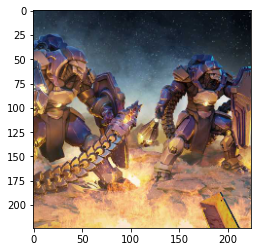

Label: imtechnology_0.5

Prediction: imtechnology_0.5, 0.5755800604820251


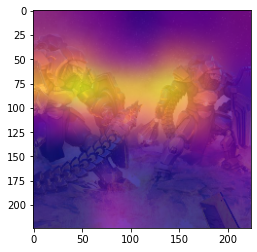

Prediction: imlandscapes_0.9, 0.14948800206184387


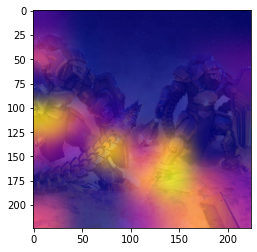

Prediction: imtechnology_1.0, 0.10593028366565704


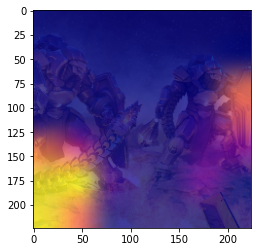

Prediction: imtechnology_0.9, 0.08042323589324951


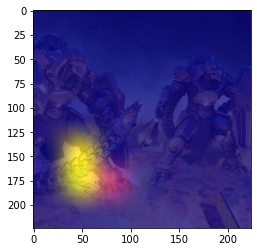

Prediction: imcharacters_0.9, 0.029086308553814888


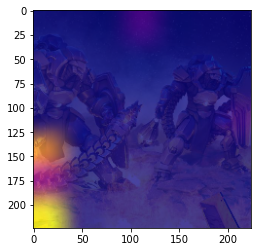

In [83]:
import random
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm
from PIL import Image

sample = random.randint(0, len(dataset) - 1)
image, label = dataset[sample]

image_plt = torch.permute(image, (1, 2, 0)).numpy()
image_size = image_plt.shape[:2]
plt.imshow(image_plt)
plt.show()

image = torch.unsqueeze(image, 0)
image = image.to(device)
image = dataset.transforms(image)

output = torch.squeeze(F.softmax(model(image), dim=-1))
topk = torch.topk(output, 5)

print(f'Label: {dataset.id_to_label(label)}\n')
for id, value in zip(topk.indices.tolist(), topk.values.tolist()):
    print(f'Prediction: {dataset.id_to_label(id)}, {value}')
    output[id].backward(retain_graph=True)

    # Grad-CAM
    features = feature_collector.features
    gradients = gradient_collector.gradients
    neuron_importance_weights = torch.mean(gradients, dim=(-1, -2), keepdim=True)
    grad_cam = F.relu(torch.sum(neuron_importance_weights * features, dim=1))
    grad_cam = torch.squeeze(grad_cam).detach().cpu().numpy()

    grad_cam = grad_cam / np.max(grad_cam)
    grad_cam = Image.fromarray(np.uint8(cm.plasma(grad_cam) * 255))
    grad_cam = grad_cam.convert('RGB')
    grad_cam = grad_cam.resize(image_size)
    grad_cam = np.asarray(grad_cam)

    plt.imshow(image_plt)
    plt.imshow(grad_cam, alpha=0.75)
    plt.show()

# Clear graph
torch.sum(output).backward(retain_graph=False)